# Homework 6

## FINM 35700 - Spring 2025

### UChicago Financial Mathematics

### Due Date: 2025-05-06

* Alex Popovici
* alex.popovici@uchicago.edu

This homework relies on multiple files (from previous weeks):

- the bond symbology file `bond_symbology`, 
- the "on-the-run" treasuries data file `govt_on_the_run`,
- the bond market data file `bond_market_prices_eod`,
- the SOFR OIS Swap symbology file `sofr_swap_symbology`,
- the SOFR OIS Swap market data file `sofr_swaps_market_data_eod`.

In [1]:
import datetime
import matplotlib.pyplot as plt
import math
from scipy.optimize import minimize
import warnings
warnings.filterwarnings("ignore")

# import tools from previous homeworks
from credit_market_tools import *

# Use static calculation/valuation date of 2024-12-13, matching data available in the market prices EOD file
calc_date = ql.Date(13, 12, 2024)
ql.Settings.instance().evaluationDate = calc_date

# Calculation/valuation date as pd datetime
as_of_date = pd.to_datetime('2024-12-13')
today = pd.to_datetime("2024-12-13") 
days_per_year = 365.25

In [2]:
# Load bond_symbology
bond_symbology = pd.read_excel("data/bond_symbology.xlsx")
bond_symbology['start_date'] = pd.to_datetime(bond_symbology['start_date'])
bond_symbology['cpn_first'] = pd.to_datetime(bond_symbology['cpn_first'])
bond_symbology['acc_first'] = pd.to_datetime(bond_symbology['acc_first'])
bond_symbology['maturity']   = pd.to_datetime(bond_symbology['maturity'])

bond_symbology['term'] = ((bond_symbology['maturity'] - bond_symbology['start_date']).dt.days / days_per_year)
bond_symbology['TTM'] = ((bond_symbology['maturity'] - today).dt.days / days_per_year)
bond_symbology['TTM'] = bond_symbology['TTM'].apply(lambda x: x if x > 0 else 0)
bond_symbology.head()

,ticker,class,figi,isin,und_bench_isin,security,name,type,coupon,cpn_type,...,acc_first,maturity,mty_typ,rank,amt_out,country,currency,status,term,TTM
0,AAPL,Corp,BBG004HST0K7,US037833AL42,US912810UF39,AAPL 3.85 05/04/43,APPLE INC,GLOBAL,3.850,FIXED,...,2013-05-03,2043-05-04,AT MATURITY,Sr Unsecured,3000.0,US,USD,ACTV,30.001369,18.387406
1,AAPL,Corp,BBG006F8VWJ7,US037833AT77,US912810UF39,AAPL 4.45 05/06/44,APPLE INC,GLOBAL,4.450,FIXED,...,2014-05-06,2044-05-06,AT MATURITY,Sr Unsecured,1000.0,US,USD,ACTV,30.001369,19.394935
2,AAPL,Corp,BBG0081TNL50,US037833BA77,US912810UF39,AAPL 3.45 02/09/45,APPLE INC,GLOBAL,3.450,FIXED,...,2015-02-09,2045-02-09,AT MATURITY,Sr Unsecured,2000.0,US,USD,ACTV,30.001369,20.158795
3,AAPL,Corp,BBG008N1BQC1,US037833BH21,US912810UF39,AAPL 4 3/8 05/13/45,APPLE INC,GLOBAL,4.375,FIXED,...,2015-05-13,2045-05-13,AT MATURITY,Sr Unsecured,2000.0,US,USD,ACTV,30.001369,20.413415
4,AAPL,Corp,BBG00C7QB7Q2,US037833BY53,US91282CLY56,AAPL 3 1/4 02/23/26,APPLE INC,GLOBAL,3.250,FIXED,...,2016-02-23,2026-02-23,CALLABLE,Sr Unsecured,3250.0,US,USD,ACTV,10.001369,1.196441


In [3]:
# Load bond_market_prices_eod
bond_market_prices_eod = pd.read_excel("data/bond_market_prices_eod.xlsx")
bond_market_prices_eod["date"] = pd.to_datetime(bond_market_prices_eod["date"])
bond_market_prices_eod["midPrice"] = (bond_market_prices_eod["bidPrice"] + bond_market_prices_eod["askPrice"])/2
bond_market_prices_eod["midYield"] = (bond_market_prices_eod["bidYield"] + bond_market_prices_eod["askYield"])/2
display(bond_market_prices_eod.head())

,date,class,ticker,isin,figi,bidPrice,askPrice,accrued,bidYield,askYield,midPrice,midYield
0,2024-12-13,Corp,AAPL,US037833BX70,BBG00C7QBG91,93.228,93.809,1.4595,5.180,5.132,93.5185,5.1560
1,2024-12-13,Corp,AAPL,US037833EK23,BBG011ZS1X57,63.723,64.232,0.9835,5.242,5.194,63.9775,5.2180
2,2024-12-13,Corp,AAPL,US037833DW79,BBG00TN2PN26,63.716,64.215,0.2585,5.253,5.205,63.9655,5.2290
3,2024-12-13,Corp,AAPL,US037833EF38,BBG00Z3VQ626,63.262,63.766,0.9420,5.249,5.200,63.5140,5.2245
4,2024-12-13,Corp,AAPL,US037833CD08,BBG00DHQX9M5,82.278,82.848,1.4120,5.227,5.177,82.5630,5.2020


In [4]:
# Load govt_on_the_run
govt_on_the_run = pd.read_excel("data/govt_on_the_run.xlsx")
on_the_run_list = ["2Y","3Y","5Y","7Y","10Y","20Y","30Y"]
pattern = r"^GT(\d+)([A-Z])?\sGovt$"
govt_on_the_run[["tenor", "suffix"]] = govt_on_the_run["ticker"].str.extract(pattern)
govt_on_the_run["tenor"] = govt_on_the_run["tenor"] + "Y"
display(govt_on_the_run.head())

,ticker,date,figi,isin,tenor,suffix
0,GT10 Govt,2024-12-13,BBG01QKHSMP5,US91282CLW90,10Y,NaN
1,GT10B Govt,2024-12-13,BBG01P1YBJQ5,US91282CLF67,10Y,B
2,GT10C Govt,2024-12-13,BBG01MPC8VJ9,US91282CKQ32,10Y,C
3,GT2 Govt,2024-12-13,BBG01QZFYJV6,US91282CLY56,2Y,NaN
4,GT20 Govt,2024-12-13,BBG01QVTC1Y0,US912810UF39,20Y,NaN


In [5]:
# Load sofr_swaps_symbology
sofr_sym = pd.read_excel('data/sofr_swaps_symbology.xlsx')
sofr_sym.head()

,figi,ticker,class,bbg,name,tenor,type,dcc,exchange,country,currency,status
0,BBG00KFWPJJ9,USOSFR1,Curncy,USOSFR1 Curncy,USD OIS ANN VS SOFR 1Y,1,SWAP,ACT/360,NONE,US,USD,ACTV
1,BBG00KFWPJX3,USOSFR2,Curncy,USOSFR2 Curncy,USD OIS ANN VS SOFR 2Y,2,SWAP,ACT/360,NONE,US,USD,ACTV
2,BBG00KFWPK15,USOSFR3,Curncy,USOSFR3 Curncy,USD OIS ANN VS SOFR 3Y,3,SWAP,ACT/360,NONE,US,USD,ACTV
3,BBG00KFWPK51,USOSFR5,Curncy,USOSFR5 Curncy,USD OIS ANN VS SOFR 5Y,5,SWAP,ACT/360,NONE,US,USD,ACTV
4,BBG00KFWPK79,USOSFR7,Curncy,USOSFR7 Curncy,USD OIS ANN VS SOFR 7Y,7,SWAP,ACT/360,NONE,US,USD,ACTV


In [6]:
# Load sofr_swaps_market_data_eod
sofr_mkt = pd.read_excel('data/sofr_swaps_market_data_eod.xlsx')
sofr_mkt['date'] = pd.to_datetime(sofr_mkt['date'])
sofr_mkt.head()

,date,figi,bidRate,askRate,midRate
0,2024-01-02,BBG00KFWPJJ9,4.7960,4.8046,4.80030
1,2024-01-02,BBG00KFWPJX3,4.1368,4.1452,4.14100
2,2024-01-02,BBG00KFWPK15,3.8258,3.8327,3.82925
3,2024-01-02,BBG00KFWPK51,3.5907,3.5943,3.59250
4,2024-01-02,BBG00KFWPK79,3.5297,3.5333,3.53150


-----------------------------------------------------------
# Parametric Credit Models: 
# Nelson-Siegel credit model for smooth hazard rate curves

### This homework  implements some of the concepts introduced in Lecture 6, "Parametric Hazard Rate Models"

### Follow the "Smooth parametric yield and hazard rate curves: the Nelson-Siegel model" in the "Smooth Credit Models" notebook
### You can also take a look at Dr. Mark Hendricks Fixed Income notebooks describing the Nelson-Siegel model calibration on US Treasuries.
-----------------------------------------------------------

-----------------------------------------------------------
# Problem 1: Market Data preparation

## a. Prepare the VZ bond market data as of 2024-12-13
Load the symbology + market data dataframes and create a combined dataframe for all Verizon (ticker = 'VZ') fixed rate (cpn_type == 'FIXED') bonds with an outstanding amount greater than $100 MM (amt_out > 100).

Sort the dataframe by bond maturity and display the head of the dataframe.

Plot the VZ yields (Y-axis) by TTM (X-axis).

In [7]:
bond_df = pd.merge(bond_symbology, bond_market_prices_eod, on=['isin', 'ticker', 'class', 'figi'], how='inner')
bond_vz = bond_df[(bond_df['ticker'] == 'VZ') & (bond_df['cpn_type'] == 'FIXED') & (bond_df['amt_out'] > 100)].sort_values(by='maturity').reset_index(drop=True)
display(bond_vz.head())

,ticker,class,figi,isin,und_bench_isin,security,name,type,coupon,cpn_type,...,term,TTM,date,bidPrice,askPrice,accrued,bidYield,askYield,midPrice,midYield
0,VZ,Corp,BBG00ZLKTF09,US92343VGG32,US91282CLY56,VZ 1.45 03/20/26,VERIZON COMMUNICATIONS,GLOBAL,1.450,FIXED,...,4.993840,1.264887,2024-12-13,96.175,96.327,0.3460,4.605,4.476,96.2510,4.5405
1,VZ,Corp,BBG00DGYP877,US92343VDD38,US91282CLY56,VZ 2 5/8 08/15/26,VERIZON COMMUNICATIONS,GLOBAL,2.625,FIXED,...,10.036961,1.670089,2024-12-13,97.011,97.315,0.8820,4.508,4.313,97.1630,4.4105
2,VZ,Corp,BBG00G6QW2B8,US92343VDY74,US91282CMB45,VZ 4 1/8 03/16/27,VERIZON COMMUNICATIONS,GLOBAL,4.125,FIXED,...,9.998631,2.253251,2024-12-13,98.920,99.067,1.0315,4.633,4.563,98.9935,4.5980
3,VZ,Corp,BBG00SK3XVL1,US92343VFF67,US91282CMB45,VZ 3 03/22/27,VERIZON COMMUNICATIONS,GLOBAL,3.000,FIXED,...,7.003422,2.269678,2024-12-13,96.470,96.700,0.7000,4.657,4.547,96.5850,4.6020
4,VZ,Corp,BBG00ZLKTF27,US92343VGH15,US91282CMA61,VZ 2.1 03/22/28,VERIZON COMMUNICATIONS,GLOBAL,2.100,FIXED,...,7.000684,3.271732,2024-12-13,92.132,92.319,0.4905,4.727,4.661,92.2255,4.6940


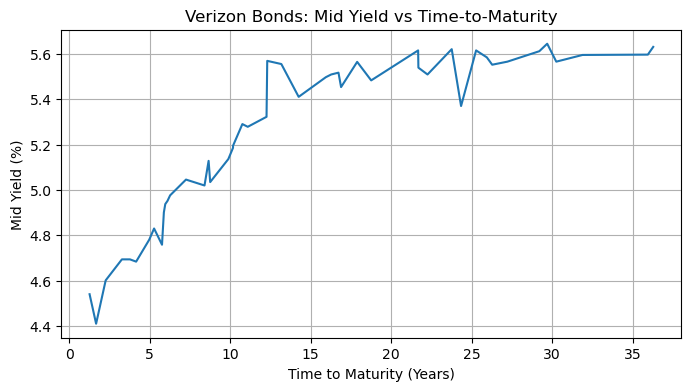

In [8]:
plt.figure(figsize=(8,4))
plt.plot(bond_vz['TTM'], bond_vz['midYield'], linestyle='-')
plt.title("Verizon Bonds: Mid Yield vs Time‐to‐Maturity")
plt.xlabel("Time to Maturity (Years)")
plt.ylabel("Mid Yield (%)")
plt.grid(True)
plt.show()

## b. Compute bond yields and risk metrics
For each bond, use the bond market mid-price as an input to compute the:

1. bond yields,
2. bond DV01s and
3. bond durations.

You can use section "9. Analytical Duration" in the QuantLib Basics notebook as a template.


In [10]:
from QuantLib import BondFunctions, InterestRate, Compounded, Semiannual, Duration

yields, mac_durs, mod_durs, dv01s = [], [], [], []

for _, row in bond_vz.iterrows():
    b = create_bond_from_symbology(row)
    price = row['midPrice']
    
    y = BondFunctions.bondYield(b, price, b.dayCounter(), Compounded, Semiannual)
    yields.append(y)
    
    ir = InterestRate(y, b.dayCounter(), Compounded, Semiannual)
    mac = BondFunctions.duration(b, ir, Duration.Macaulay)
    mod = BondFunctions.duration(b, ir, Duration.Modified)
    mac_durs.append(mac)
    mod_durs.append(mod)    
    dv01s.append(mod * price / 100)

bond_vz['yield'] = yields
bond_vz['macaulay_duration'] = mac_durs
bond_vz['modified_duration'] = mod_durs
bond_vz['DV01'] = dv01s

display(bond_vz[['isin','maturity','yield','macaulay_duration','modified_duration','DV01']].head())

,isin,maturity,yield,macaulay_duration,modified_duration,DV01
0,US92343VGG32,2026-03-20,0.045406,1.250067,1.222316,1.176491
1,US92343VDD38,2026-08-15,0.044101,1.624585,1.589535,1.544440
2,US92343VDY74,2027-03-16,0.045982,2.150331,2.102004,2.080847
3,US92343VFF67,2027-03-22,0.046018,2.192197,2.142891,2.069711
4,US92343VGH15,2028-03-22,0.046938,3.153604,3.081289,2.841734


## c. Calibrate the US Treasury curve
### Calibrate the "on-the-run" US Treasury curveas of 2024-12-13:

... to be used in the hazard rate model calibration.

In [11]:
from QuantLib import YieldTermStructureHandle

us_treasury_bonds = bond_symbology[(bond_symbology["class"] == "Govt") & (bond_symbology["ticker"] == "T")]
on_the_run_bonds = govt_on_the_run[(govt_on_the_run["tenor"].isin(on_the_run_list)) & (govt_on_the_run["suffix"].isna())].copy()
us_treasuries_on_the_run = pd.merge(us_treasury_bonds, on_the_run_bonds, on=['figi', 'isin']).drop(["suffix", "ticker_y"], axis=1).rename(columns={"ticker_x": "ticker"})

bond_market_prices_eod = bond_market_prices_eod[bond_market_prices_eod["date"]=="2024-12-13"]
us_treasuries_on_the_run_mkt = pd.merge(us_treasuries_on_the_run, bond_market_prices_eod, on=list(set(us_treasuries_on_the_run.columns).intersection(set(bond_market_prices_eod))))

govt_combined_otr = us_treasuries_on_the_run_mkt   
tsy_yield_curve = calibrate_yield_curve_from_frame(calc_date, govt_combined_otr, 'midPrice')
tsy_yield_curve_handle = ql.YieldTermStructureHandle(tsy_yield_curve)

-----------------------------------------------------------
# Problem 2: Add functions needed to calibrate the Nelson-Siegel (4 parameters) credit model

## a. For a given set of Nelson-Siegel curve shape parameters, write a function to create the corresponding parametric credit curve.
The result should be a DefaultProbabilityTermStructureHandle object, to be used downstream for pricing.

In [12]:
def create_nelson_siegel_curve(calc_date, nelson_siegel_params):
    ''' nelson_siegel_params = (theta1, theta2, theta3, lambda)'''
    
    theta1, theta2, theta3, lamb = nelson_siegel_params

    max_tenor = 40
    tenors = list(range(0, max_tenor + 1))
    dates = [calc_date + ql.Period(t, ql.Years) for t in tenors]

    eps = 1e-8
    surv_probs = []
    for t in tenors:
        if t == 0:
            surv_probs.append(1.0)
        else:
            slope     = (1 - math.exp(-t / lamb)) / (t / lamb)
            curvature = slope - math.exp(-t / lamb)
            hz        = theta1 + theta2 * slope + theta3 * curvature
            hz        = max(eps, hz)
            surv_probs.append(math.exp(-hz * t))

    curve = ql.SurvivalProbabilityCurve(
        dates,
        surv_probs,
        ql.Actual365Fixed(),
        ql.TARGET()
    )
    curve.enableExtrapolation()

    return ql.DefaultProbabilityTermStructureHandle(curve)

## b. Write a function to price all bonds in the Nelson-Siegel credit model

Use 40% recovery rate.

Using DefaultProbabilityTermStructureHandle as an input to compute all model prices and yields.

In [13]:
def calculate_nelson_siegel_model_prices_and_yields(nelson_siegel_params, 
                      calc_date, 
                      fixed_rate_bond_objects, 
                      tsy_yield_curve_handle, 
                      bond_recovery_rate = 0.4):
    
    credit_handle = create_nelson_siegel_curve(calc_date, nelson_siegel_params)
    engine = ql.RiskyBondEngine(credit_handle, bond_recovery_rate, tsy_yield_curve_handle)

    bond_model_prices = []
    bond_model_yields = []

    for bond in fixed_rate_bond_objects:
        bond.setPricingEngine(engine)
        p = bond.cleanPrice()
        y = bond.bondYield(p, bond.dayCounter(), ql.Compounded, ql.Semiannual)

        bond_model_prices.append(p)
        bond_model_yields.append(y)

    return bond_model_prices, bond_model_yields

## c. Write a function to computes the weighted SSE / "Sum of Squared Errors" metric
Write a function to compute the weighted SSE / "Sum of Squared Errors" in price space, defined as sum of squared differences between model and market prices for all Verizon fixed-rate bonds.

Use 1/DV01 as SSE weights, as discussed in Lecture 6. You can ignore the liquidity adjuster for the purpose of this exercise.

In [14]:
def nelson_siegel_sse(nelson_siegel_params, 
                      calc_date, 
                      fixed_rate_bond_objects, 
                      market_prices, 
                      calib_weights,
                      tsy_yield_curve_handle, 
                      bond_recovery_rate = 0.4):
    
    model_prices, _ = calculate_nelson_siegel_model_prices_and_yields(
        nelson_siegel_params,
        calc_date,
        fixed_rate_bond_objects,
        tsy_yield_curve_handle,
        bond_recovery_rate
    )

    mkt = np.asarray(market_prices, dtype=float)
    mdl = np.asarray(model_prices,  dtype=float)
    wts = np.asarray(calib_weights,  dtype=float)

    if not (mkt.shape == mdl.shape == wts.shape):
        raise ValueError("Lengths of market_prices, model_prices, and calib_weights must match.")

    return float(np.sum(wts * (mkt - mdl)**2))

## d. Test the functionalty on the initial set of model parameters: 
## initial_nelson_siegel_params = [0.03, -0.01, 0.02, 5.0]

Compute the corresponding initial model prices and yields, as well as initial SSE.

Add following columns to the VZ dataframe and display the head of the results:

| duration | calib_weight | initModelPrice | initModelYield |
|----------|----------|----------|----------|


In [15]:
fixed_rate_bond_objects = [
    create_bond_from_symbology(row)
    for _, row in bond_vz.iterrows()
]

market_prices  = bond_vz['midPrice'].values
calib_weights  = 1.0 / bond_vz['DV01'].values

initial_nelson_siegel_params = [0.03, -0.01, 0.02, 5.0]

init_prices, init_yields = calculate_nelson_siegel_model_prices_and_yields(
    initial_nelson_siegel_params,
    calc_date,
    fixed_rate_bond_objects,
    tsy_yield_curve_handle,
    bond_recovery_rate=0.4
)
initial_sse = nelson_siegel_sse(
    initial_nelson_siegel_params,
    calc_date,
    fixed_rate_bond_objects,
    market_prices,
    calib_weights,
    tsy_yield_curve_handle,
    bond_recovery_rate=0.4
)

bond_vz['duration'] = bond_vz['modified_duration']
bond_vz['calib_weight'] = calib_weights
bond_vz['initModelPrice'] = init_prices
bond_vz['initModelYield'] = init_yields

display(bond_vz[['isin','maturity','duration','calib_weight','initModelPrice','initModelYield']].head())
print(f"Initial Nelson–Siegel SSE: {initial_sse:.8f}")

,isin,maturity,duration,calib_weight,initModelPrice,initModelYield
0,US92343VGG32,2026-03-20,1.222316,0.849985,95.146125,0.054840
1,US92343VDD38,2026-08-15,1.589535,0.647484,95.309715,0.056144
2,US92343VDY74,2027-03-16,2.102004,0.480574,96.660427,0.057245
3,US92343VFF67,2027-03-22,2.142891,0.483159,94.369654,0.056799
4,US92343VGH15,2028-03-22,3.081289,0.351898,89.133337,0.057981


Initial Nelson–Siegel SSE: 266.72926258


-----------------------------------------------------------
# Problem 3: Calibrate the Nelson-Siegel model
## a. Find the Nelson-Siegel model parameters providing the smooth credit curve which best fits the market.

Use the US "on-the-run" Treasury yield curve for risk-free discounting.

Minimize the SSE (model vs market pricing error) function to obtain the optimal/calibrated Nelson-Siegel parameter vector. 

Create the calibrated/smooth credit curve corresponding to the optimal model parameters.

In [16]:
def calibrate_nelson_siegel_model(initial_nelson_siegel_params,
                                  calc_date, 
                                  bond_details, 
                                  tsy_yield_curve_handle, 
                                  bond_recovery_rate = 0.4):
    
    bond_objs = [create_bond_from_symbology(row)for _, row in bond_details.iterrows()]

    bounds = [(1e-6, 0.20), (-0.10, 0.0), (-0.10, 0.10), (0.10, 10.0)]

    def objective(params):
        return nelson_siegel_sse(
            params,
            calc_date,
            bond_objs,
            bond_details['midPrice'].values,
            bond_details['calib_weight'].values,
            tsy_yield_curve_handle,
            bond_recovery_rate
        )

    result = minimize(
        objective,
        x0=np.array(initial_nelson_siegel_params, dtype=float),
        method='L-BFGS-B',
        bounds=bounds,
        options={'ftol':1e-12, 'maxiter':500}
    )

    if not result.success:
        raise RuntimeError(f"Calibration failed: {result.message}")

    theta1, theta2, theta3, lamb = result.x
    return (float(theta1), float(theta2), float(theta3), float(lamb))

## b. Compute smooth model prices, yields and "edges"

Price all Verizon bonds on the calibrated credit curve and compute the corresponding model yields and edges.

Add following columns to the dataframe and display the head of the results:

| modelPrice | modelYield | edgePrice | edgeYield |
|----------|----------|----------|----------|


In [17]:
opt_params = calibrate_nelson_siegel_model(
    initial_nelson_siegel_params,
    calc_date,
    bond_vz,
    tsy_handle,
    bond_recovery_rate=0.4
)

fixed_rate_bond_objects = [create_bond_from_symbology(row)for _, row in bond_vz.iterrows()]

model_prices, model_yields = calculate_nelson_siegel_model_prices_and_yields(
    opt_params,
    calc_date,
    fixed_rate_bond_objects,
    tsy_handle,
    bond_recovery_rate=0.4
)

bond_vz = bond_vz.copy()
bond_vz['modelPrice'] = model_prices
bond_vz['modelYield'] = [my*100 for my in model_yields]
bond_vz['edgePrice'] = bond_vz['midPrice'] - bond_vz['modelPrice']
bond_vz['edgeYield'] = bond_vz['midYield'] - bond_vz['modelYield']
bond_vz['edgeYield'] = [ey*100 for ey in model_yields]

display(bond_vz[['isin', 'maturity', 'duration', 'calib_weight', 'midPrice', 'modelPrice', 'edgePrice', 'midYield', 'modelYield', 'edgeYield']].head())

NameError: name 'tsy_handle' is not defined

-----------------------------------------------------------
# Problem 4: Visualize the results of the credit model calibration

## a. Plot the model vs market prices (Y-axis) by maturity (X-axis).

## b. Plot the model vs market yields (Y-axis) by maturity (X-axis).

## c. Plot the edges in yield space (Y-axis) by maturity (X-axis).

## d. What do you think about the quality of the model fit?



In [ ]:
x = bond_vz['TTM'].values

In [ ]:
def plot_model_vs_market(
    df, x_col, market_col, model_col, title, y_label):
    plt.figure(figsize=(8, 5))
    plt.plot(df[x_col], df[market_col],
             marker='o', linestyle='-', label='Market')
    plt.plot(df[x_col], df[model_col],
             marker='x', linestyle='--', label='Model')
    plt.title(title)
    plt.xlabel("Time to Maturity (Years)")
    plt.ylabel(y_label)
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_yield_edge(
    df, x_col, market_yield_col, model_yield_col, title):
    edge_bps = (df[market_yield_col] - df[model_yield_col]) * 100
    plt.figure(figsize=(8, 5))
    plt.plot(df[x_col], edge_bps,
             marker='o', linestyle='-')
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.title(title)
    plt.xlabel("Time to Maturity (Years)")
    plt.ylabel("Yield Difference (bps)")
    plt.grid(True)
    plt.show()

In [ ]:
plot_model_vs_market(
    bond_vz,
    x_col='TTM',
    market_col='midPrice',
    model_col='modelPrice',
    title="Verizon Bond Prices: Model vs Market",
    y_label="Clean Price"
)

In [ ]:
plot_model_vs_market(
    bond_vz,
    x_col='TTM',
    market_col='midYield',
    model_col='modelYield',
    title="Verizon Bond Yields: Model vs Market",
    y_label="Yield (%)"
)

In [ ]:
plot_yield_edge(
    bond_vz,
    x_col='TTM',
    market_yield_col='midYield',
    model_yield_col='modelYield',
    title="Verizon Bond Yield Edge (Market – Model)"
)

- All three plots show an alignment between the Nelson–Siegel model and observed Verizon bond prices and yields.
- The price overlay chart exhibits very close lines for market vs. model, and the yield chart also shows a very close overlap.
- In the yield edge subplot, residuals cluster around zero with values within typical bid-ask spreads, and there is no systematic bias across maturities.
- The four parameter Nelson Siegel hazard rate specification is accurate and parsimonious fit to the credit spread term structure.